In [429]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import textalloc as ta

In [245]:
DATA = pd.read_csv('../data/processed/throwing_0627.csv').dropna(how='any', axis=0)

In [348]:
features = ['thrower_x', 'thrower_y', 'possession_num', 'possession_throw',
       'game_quarter', 'quarter_point', 'is_home_team', 'home_team_score',
       'away_team_score','total_points', 'times']
label = ['home_team_win']

grouped = DATA.groupby(['gameID'])

# Step 2: Sort the groups by length
sorted_groups = sorted(grouped[features + label], key=lambda x: len(x[1]), reverse=True)

# Step 3: Convert each group to a numpy array
group_arrays = []
for _, group in sorted_groups:
    group_array = group.values  # Convert group DataFrame to a numpy array
    group_arrays.append(group_array)

# Step 4: Pad the variable-length groups
max_length = max(len(arr) for arr in group_arrays)
padded_arrays = []
for arr in group_arrays:
    pad_width = ((max_length - len(arr), 0), (0, 0))  # Pad at the beginning with zeros
    padded_array = np.pad(arr, pad_width, mode='constant', constant_values=-1)
    padded_arrays.append(padded_array)

# Step 5: Convert the list of arrays into a 3D numpy array
data_array = np.stack(padded_arrays)

In [247]:
X_train, X_test, y_train, y_test = train_test_split(data_array[:,:,:11], data_array[:,:,11], test_size=0.2, random_state=42)

In [248]:
# Create a normalizer object
normalizer = MinMaxScaler()

# Flatten the 3D training data
X_train_flattened = X_train.reshape(-1, X_train.shape[-1])

# Create a mask for padded values
mask = (X_train_flattened[:, 0] != -1)

# Apply normalization only to non-padded values
X_train_normalized = X_train_flattened.copy()
X_train_normalized[mask] = normalizer.fit_transform(X_train_flattened[mask])

# Reshape the normalized data back to the original shape
X_train_normalized = X_train_normalized.reshape(X_train.shape)

# Apply the same normalization to the test data
X_test_flattened = X_test.reshape(-1, X_test.shape[-1])
mask = (X_test_flattened[:, 0] != -1)
X_test_flattened = X_test.reshape(-1, X_test.shape[-1])
X_test_normalized = X_test_flattened.copy()
X_test_normalized[mask] = normalizer.transform(X_test_flattened[mask])
X_test_normalized = X_test_normalized.reshape(X_test.shape)

In [249]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
X_train_normalized = X_train_normalized.astype(np.float32)
X_test_normalized = X_test_normalized.astype(np.float32)

In [253]:
model = tf.keras.Sequential()

# Add BatchNormalization layer
# model.add(tf.keras.layers.BatchNormalization(input_shape=(629, 11)))

# Add LSTM layer
model.add(tf.keras.layers.LSTM(units=64, return_sequences=True))

# Add LayerNormalization layer
model.add(tf.keras.layers.LayerNormalization())

# Add a Dense layer with sigmoid activation
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))


In [254]:
def masked_loss(mask_value):
    def loss_function(y_true, y_pred):
        mask = tf.math.not_equal(y_true, mask_value)
        masked_pred = tf.boolean_mask(y_pred, mask)
        masked_true = tf.boolean_mask(y_true, mask)
        loss = tf.keras.losses.binary_crossentropy(masked_true, masked_pred)
        return loss
    return loss_function
learning_rate = 0.001  # Specify your desired learning rate

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=masked_loss(mask_value=-1), metrics=['accuracy'])

In [255]:
model.fit(X_train_normalized, y_train, batch_size=16, epochs=10, validation_data=(X_test_normalized, y_test))

Epoch 1/10


2023-06-27 02:06:11.442255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-27 02:06:11.780685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-27 02:06:13.523127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.4209

2023-06-27 02:06:27.979188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-27 02:06:28.162665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 21s 821ms/step - loss: 0.6941 - accuracy: 0.4209 - val_loss: 0.6413 - val_accuracy: 0.4967
Epoch 2/10
18/18 [==============================] - 6s 322ms/step - loss: 0.6086 - accuracy: 0.5025 - val_loss: 0.5395 - val_accuracy: 0.5797
Epoch 3/10
18/18 [==============================] - 6s 313ms/step - loss: 0.5133 - accuracy: 0.5421 - val_loss: 0.4241 - val_accuracy: 0.6027
Epoch 4/10
18/18 [==============================] - 6s 313ms/step - loss: 0.4869 - accuracy: 0.5480 - val_loss: 0.4454 - val_accuracy: 0.5984
Epoch 5/10
18/18 [==============================] - 6s 308ms/step - loss: 0.4475 - accuracy: 0.5723 - val_loss: 0.4101 - val_accuracy: 0.6021
Epoch 6/10
18/18 [==============================] - 6s 323ms/step - loss: 0.4187 - accuracy: 0.5833 - val_loss: 0.4062 - val_accuracy: 0.6027
Epoch 7/10
18/18 [==============================] - 6s 336ms/step - loss: 0.4251 - accuracy: 0.5766 - val_loss: 0.4140 - val_accuracy: 0.6040
Epoch 8/10
18/18

In [257]:
X_test_normalized[1,:,:].shape

(629, 11)

In [301]:
sum(y_test[0,:] != -1)

493

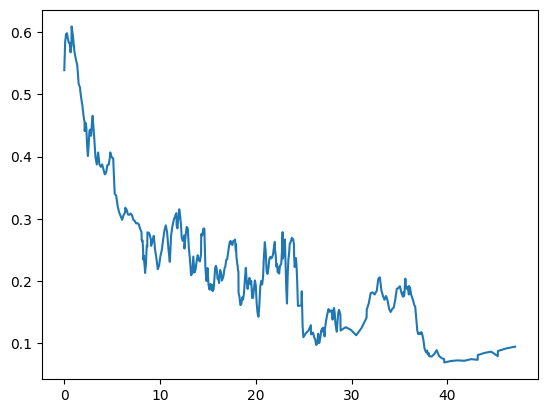

In [314]:
game = 2
out = model.predict(X_test_normalized[game,:,:].reshape(1, 629, 11))
df = pd.DataFrame(X_test[game,:,:], columns=features)
preds = out[np.array([df.times > 0])]
plt.plot(48 - df[df.times > 0].times/60, preds)

In [318]:
[x for x in DATA.gameID.unique() if 'BOS' in x]

['2023-05-20-BOS-MTL',
 '2023-06-11-BOS-MTL',
 '2023-05-13-PHI-BOS',
 '2023-05-06-TOR-BOS',
 '2023-06-16-BOS-NY',
 '2022-06-03-BOS-DC',
 '2023-06-09-ATL-BOS',
 '2023-06-02-NY-BOS',
 '2021-06-05-BOS-PIT',
 '2022-06-25-BOS-TOR',
 '2021-06-19-BOS-RAL',
 '2021-08-20-BOS-NY',
 '2021-06-18-BOS-DC',
 '2022-04-30-PHI-BOS',
 '2022-05-07-BOS-MTL',
 '2022-05-14-NY-BOS',
 '2022-05-20-TOR-BOS',
 '2021-06-25-TB-BOS',
 '2021-08-21-BOS-PHI',
 '2022-07-02-MTL-BOS',
 '2021-08-06-RAL-BOS',
 '2021-06-11-ATL-BOS',
 '2022-05-06-BOS-OTT',
 '2021-07-10-PHI-BOS',
 '2021-08-29-NY-BOS',
 '2021-07-24-BOS-TB',
 '2021-08-13-PIT-BOS',
 '2022-07-09-BOS-NY',
 '2022-06-04-BOS-PHI']

/Users/bradeneberhard/miniforge3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


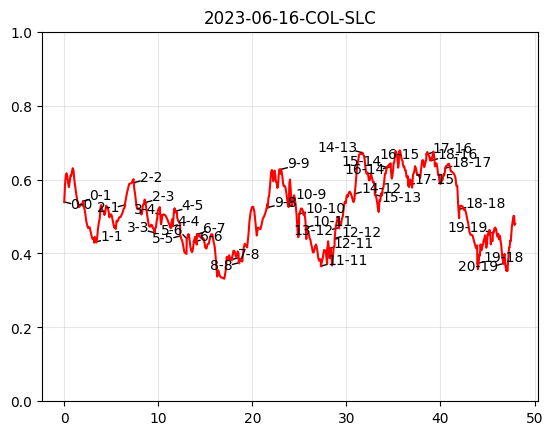

In [450]:
gameID = '2023-06-16-COL-SLC'
test_game = DATA[DATA.gameID == gameID][features]
test_game = normalizer.transform(test_game)
pad_width = ((max_length - len(test_game), 0), (0, 0))  # Pad at the beginning with zeros
test_game = np.pad(test_game, pad_width, mode='constant', constant_values=-1).astype(np.float32)
out = model.predict(test_game.reshape(1, 629, 11))
df = pd.DataFrame(normalizer.inverse_transform(test_game), columns=features)
preds = out[np.array([df.times > 0])].flatten()
annotations = []
counter = 0
txts, xs, ys = [], [], []
for _, group_df in df[df.times>0].groupby('total_points'):
    counter = counter + 1
    row = group_df.iloc[0]
    txt = f'{int(row.home_team_score)}-{int(row.away_team_score)}'
    x = 48 - row.times/60
    y = out.flatten()[min(group_df.index)]
    txts.append(txt)
    xs.append(x)
    ys.append(y)
fig, ax = plt.subplots()
ax.scatter(xs, ys, c='r', s=0.1)
ta.allocate_text(fig,ax,xs,ys,
                txts,
                x_scatter=xs, y_scatter=ys,
                textsize=10, linecolor='black')


plt.plot(48 - df[df.times > 0].times/60, preds, c='r')
plt.grid(alpha=0.3)
plt.title(gameID)
plt.ylim([0,1])
plt.show()

/Users/bradeneberhard/miniforge3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


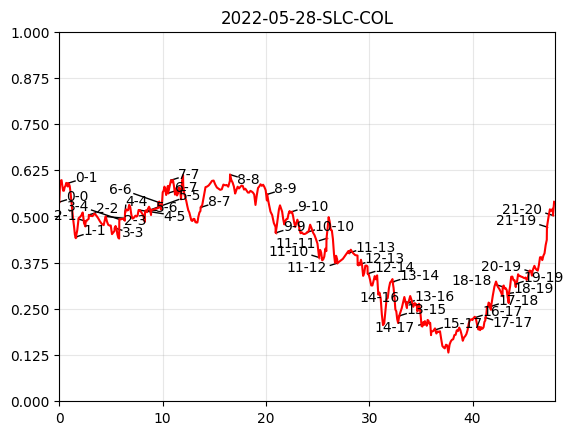

In [462]:
gameID = '2022-05-28-SLC-COL'
test_game = DATA[DATA.gameID == gameID][features]
test_game = normalizer.transform(test_game)
pad_width = ((max_length - len(test_game), 0), (0, 0))  # Pad at the beginning with zeros
test_game = np.pad(test_game, pad_width, mode='constant', constant_values=-1).astype(np.float32)
out = model.predict(test_game.reshape(1, 629, 11))
df = pd.DataFrame(normalizer.inverse_transform(test_game), columns=features)
preds = out[np.array([df.times > 0])].flatten()
annotations = []
counter = 0
txts, xs, ys = [], [], []
for _, group_df in df[df.times>0].groupby('total_points'):
    counter = counter + 1
    row = group_df.iloc[0]
    txt = f'{int(row.home_team_score)}-{int(row.away_team_score)}'
    x = 48 - row.times/60
    y = out.flatten()[min(group_df.index)]
    txts.append(txt)
    xs.append(x)
    ys.append(y)
fig, ax = plt.subplots()
ax.scatter(xs, ys, c='r', s=0.1)
ta.allocate_text(fig,ax,xs,ys,
                txts,
                x_scatter=xs, y_scatter=ys,
                textsize=10, linecolor='black')


plt.plot(48 - df[df.times > 0].times/60, preds, c='r')
plt.grid(alpha=0.3)
plt.yticks(np.arange(0, 1.1, 0.125))
plt.title(gameID)
plt.ylim([0,1])
plt.xlim([0,48])
plt.show()

In [449]:
[x for x in DATA.gameID.unique() if 'SLC' in x]

['2023-05-19-LA-SLC',
 '2023-04-28-SEA-SLC',
 '2023-05-05-SLC-POR',
 '2023-06-03-OAK-SLC',
 '2023-06-16-COL-SLC',
 '2023-06-09-SLC-COL',
 '2023-05-13-SLC-OAK',
 '2023-05-06-SLC-SEA',
 '2022-07-09-SLC-POR',
 '2022-06-03-OAK-SLC',
 '2022-07-08-SLC-SEA',
 '2022-08-13-SD-SLC',
 '2022-08-20-SLC-COL',
 '2022-05-28-SLC-COL',
 '2022-05-13-SEA-SLC',
 '2022-04-29-SLC-SD',
 '2022-04-30-SLC-LA',
 '2022-06-10-COL-SLC',
 '2022-06-24-SD-SLC',
 '2022-07-16-SLC-OAK',
 '2022-07-29-POR-SLC',
 '2022-07-22-LA-SLC']